In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
from sklearn.metrics import roc_auc_score, accuracy_score
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader
from src_py.cpmix_utils import preprocess_data
from src_py.rhorho import RhoRhoEvent
from src_py.a1a1 import A1A1Event
from src_py.a1rho import A1RhoEvent
from src_py.data_utils import read_np, EventDatasets
from src_py.process_background import convert_bkgd_raw
import train_rhorho, train_a1rho, train_a1a1
from src_py.metrics_utils import calculate_deltas_unsigned, calculate_deltas_signed
import seaborn as sns
import matplotlib.patches as mpatches
from ROOT import Math
from sklearn.metrics import confusion_matrix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Instructions for updating:
non-resource variables are not supported in the long term
Welcome to JupyROOT 6.24/06


In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device='cpu'
print('Using {} device'.format(device))

Using cpu device


In [7]:
batch_size=128
types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

decaymodes = ['rhorho', 'a1rho', 'a1a1']
decaymode = decaymodes[0]  ###### Change this to corresponding decaymode ############

parser.add_argument("-i", "--input", dest="IN", default='HiggsCP_data/'+ decaymode)
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_'+ decaymode)

parser.add_argument("--num_classes", dest="NUM_CLASSES", type=int, default=11)
parser.add_argument("-l", "--layers", dest="LAYERS", type=int, help = "number of NN layers", default=6)
parser.add_argument("-s", "--size", dest="SIZE", type=int, help="NN size", default=100)
parser.add_argument("-lambda", "--lambda", type=float, dest="LAMBDA", help="value of lambda parameter", default=0.0)
parser.add_argument("-m", "--method", dest="METHOD", choices=["A", "B", "C"], default="A")
parser.add_argument("-o", "--optimizer", dest="OPT", 
    choices=["GradientDescentOptimizer", "AdadeltaOptimizer", "AdagradOptimizer",
         "ProximalAdagradOptimizer", "AdamOptimizer", "FtrlOptimizer",
         "ProximalGradientDescentOptimizer", "RMSPropOptimizer"], default="AdamOptimizer")
parser.add_argument("-d", "--dropout", dest="DROPOUT", type=float, default=0.0)
parser.add_argument("-e", "--epochs", dest="EPOCHS", type=int, default=3)
# parser.add_argument("-f", "--features", dest="FEAT", help="Features", default="Variant-All")
# #         choices= ["Variant-All", "Variant-1.0", "Variant-1.1", "Variant-2.0", "Variant-2.1",
# #                   "Variant-2.2", "Variant-3.0", "Variant-3.1", "Variant-4.0", "Variant-4.1"])

parser.add_argument("--miniset", dest="MINISET", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)


parser.add_argument("--delt_classes", dest="DELT_CLASSES", type=int, default=0,
                    help='Maximal distance between predicted and valid class for event being considered as correctly classified')

parser.add_argument("--unweighted", dest="UNWEIGHTED", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--reuse_weights", dest="REUSE_WEIGHTS", type=bool, default=False)
parser.add_argument("--restrict_most_probable_angle", dest="RESTRICT_MOST_PROBABLE_ANGLE", type=bool, default=False)
parser.add_argument("--force_download", dest="FORCE_DOWNLOAD", type=bool, default=False)
parser.add_argument("--normalize_weights", dest="NORMALIZE_WEIGHTS", type=bool, default=False)


parser.add_argument("--beta",  type=float, dest="BETA", help="value of beta parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_b", type=float, dest="pol_b", help="value of b parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_c", type=float, dest="pol_c", help="value of c parameter for polynomial smearing", default=0.0)

parser.add_argument("--w1", dest="W1")
parser.add_argument("--w2", dest="W2")
parser.add_argument("--f", dest="FEAT", default="Variant-All")
parser.add_argument("--plot_features", dest="PLOT_FEATURES", choices=["NO", "FILTER", "NO-FILTER"], default="NO")
parser.add_argument("--training_method", dest="TRAINING_METHOD", choices=["soft_weights", "soft_c012s",  "soft_argmaxs", "regr_c012s", "regr_weights", "regr_argmaxs"], default="soft_weights")
parser.add_argument("--hits_c012s", dest="HITS_C012s", choices=["hits_c0s", "hits_c1s",  "hits_c2s"], default="hits_c0s")

parser.add_argument("-r", "--reprocess", dest="REPRO", type=bool, default=True)
parser.add_argument("-PtEtaPhi", dest="PTETAPHI", type=bool, default=True)
parser.add_argument("-dropneu", dest="DROPNEU", type=bool, default=False)
parser.add_argument("--z_noise_fraction", dest="Z_NOISE_FRACTION", type=float, default=1.0)
args, unknown = parser.parse_known_args()
parser.add_argument("-bkgd", "--bkgdpath", dest="BKGDPATH", default= 'Ztt_dataset_Elz/pythia.Z_115_135.%s.1M.*.outTUPLE_labFrame')
args, unknown = parser.parse_known_args()

In [4]:
### Suffix
suffix = ''
if args.Z_NOISE_FRACTION > 0:
    suffix = suffix + '_w_background_'+str(args.Z_NOISE_FRACTION)
if args.Z_NOISE_FRACTION == 0: 
    suffix = suffix + '_wo_background'
if args.PTETAPHI:
    suffix = suffix + '_PtEtaPhi'
if args.DROPNEU: 
    suffix = suffix + '_dropneutrino'

In [5]:
suffix

'_w_background_1.0_PtEtaPhi'

## Truth-level Training and Testing

### Preprocessing signal samples from all the decaymodes

In [8]:
events={'nn_rhorho':'RhoRhoEvent', 'nn_a1rho':'A1RhoEvent', 'nn_a1a1':'A1A1Event'}
if args.REPRO:
#     for decaymode in tqdm(decaymodes):
    args.IN = 'HiggsCP_data/'+decaymode
    args.TYPE = 'nn_'+decaymode
    data, weights, argmaxs, perm, c012s, hits_argmaxs, hits_c012s = preprocess_data(args)
    event = eval(events[args.TYPE])(data, args)
    if args.PTETAPHI:
        rhorho_raw_H = event.cols[:, :-1]
        df_rhorho_raw_H = pd.DataFrame(rhorho_raw_H)
        particle_name = ['n', 'pi-', 'pi0_1', 'an', 'pi+', 'pi0_2']
        df_rhorho_raw_H.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
        particle_PtEtaPhi={}
        for particle in particle_name:
            total_res={}
            for index, row in tqdm(df_rhorho_raw_H[particle].iloc[:, :4].iterrows(),total=df_rhorho_raw_H[particle].iloc[:, :4].shape[0]):
                res=Math.PxPyPzEVector(*row.values.tolist())
                total_res[index]=(res.pt(), res.eta(), res.phi(), row.E)
            particle_PtEtaPhi[particle]=total_res
        PtEtaPhi = [pd.DataFrame(particle_PtEtaPhi[particle].values(),columns=[particle+x for x in ['_pt','_eta','_phi','_E']]) for particle in particle_name]
        PtEtaPhi=pd.concat(PtEtaPhi,axis=1)
        if args.DROPNEU: 
            drop_neu_PtEtaPhi = PtEtaPhi.drop(sum([[particle+x for x in ['_pt','_eta','_phi','_E']] for particle in ['n', 'an']],[]), axis=1)
            drop_neu_PtEtaPhi.insert(drop_neu_PtEtaPhi.shape[1], 'filter', event.cols[:,-1])
            event.cols=drop_neu_PtEtaPhi.values
        else:
            event.cols[:,:-1] = PtEtaPhi.values
            
    points = EventDatasets(event, weights, argmaxs, perm, c012s=c012s, hits_argmaxs=hits_argmaxs,  hits_c012s=hits_c012s, miniset=args.MINISET, unweighted=args.UNWEIGHTED, raw=False)
    pickle.dump(points,open(args.IN+'/events'+suffix+'.pk','wb'))

Loading data
Read 1000000 events
Events including background: 2000000


  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

SCALE!!


### Loading signal samples

In [20]:
points=pickle.load(open(args.IN+'/events'+suffix+'.pk','rb'))
# points=pickle.load(open('HiggsCP_data/rhorho/events_w_background_1.0_PtEtaPhi.pk','rb'))

### Training NN

In [21]:
class MyDataset(Dataset):
    def __init__(self, rhorho_data_mc,rhorho_data_true,rhorho_labels_mc,rhorho_labels_true):
        self.rhorho_data_mc = torch.from_numpy(rhorho_data_mc).float().to(device)
        self.rhorho_data_true = torch.from_numpy(rhorho_data_true).float().to(device)
        
        self.rhorho_labels_mc =torch.from_numpy(rhorho_labels_mc).float().to(device)
        self.rhorho_labels_true =torch.from_numpy(rhorho_labels_true).float().to(device)
    def __getitem__(self, index):
        return self.rhorho_data_mc[index],self.rhorho_data_true[index],self.rhorho_labels_mc[index],self.rhorho_labels_true[index]
    def __len__(self):
        return min(len(self.rhorho_labels_mc),len(self.rhorho_labels_true))

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes, num_layers=1, size=100, lr=1e-3, drop_prob=0, inplace=False, 
                 tloss="regr_weights", activation='linear', input_noise=0.0, optimizer="AdamOptimizer"):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(num_features,size,bias=False)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(size,size,bias=False),
                           nn.BatchNorm1d(size),
                           nn.ReLU(),
                           nn.Dropout(drop_prob, inplace)
                          ])
        self.linear_relu_stack = nn.Sequential(*layers)
        self.linear2 = nn.Linear(size,num_classes,bias=False)
        self.linear3 = nn.Linear(size,2,bias=False)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear_relu_stack(x)
        out = self.linear2(x)
        return out

In [23]:
mc_train_idx=np.random.choice(np.arange(points.train.x.shape[0]),int(points.train.x.shape[0]*0.5),replace=False)
true_train_idx=list(set(np.arange(points.train.x.shape[0]))-set(mc_train_idx))

mc_valid_idx=np.random.choice(np.arange(points.valid.x.shape[0]),int(points.valid.x.shape[0]*0.5),replace=False)
true_valid_idx=list(set(np.arange(points.valid.x.shape[0]))-set(mc_train_idx))

mc_test_idx=np.random.choice(np.arange(points.test.x.shape[0]),int(points.test.x.shape[0]*0.5),replace=False)
true_test_idx=list(set(np.arange(points.test.x.shape[0]))-set(mc_train_idx))

In [24]:
uncertainty=0.0

train_datasets_truth = MyDataset(points.train.x[mc_train_idx], points.train.x[true_train_idx]+uncertainty*np.random.normal(0,1,size=points.train.x[true_train_idx].shape),
                          points.train.weights[mc_train_idx],points.train.weights[true_train_idx])
train_loader_truth = DataLoader(dataset = train_datasets_truth,batch_size = batch_size,shuffle = True)


valid_datasets_truth = MyDataset(points.valid.x[mc_valid_idx], points.valid.x[true_valid_idx]+uncertainty*np.random.normal(0,1,size=points.valid.x[true_valid_idx].shape),
                          points.valid.weights[mc_valid_idx],points.valid.weights[true_valid_idx])
valid_loader_truth = DataLoader(dataset = valid_datasets_truth,batch_size = batch_size,shuffle = True)


test_datasets_truth = MyDataset(points.test.x[mc_test_idx], points.test.x[true_test_idx]+uncertainty*np.random.normal(0,1,size=points.test.x[true_test_idx].shape),
                          points.test.weights[mc_test_idx],points.test.weights[true_test_idx])
test_loader_truth = DataLoader(dataset = test_datasets_truth,batch_size = batch_size,shuffle = True)

In [25]:
model_path = os.path.join(os.getcwd() + '/model')
if not os.path.exists(model_path): 
    os.mkdir(os.path.join(model_path))
if args.Z_NOISE_FRACTION > 0: 
    num_classes = args.NUM_CLASSES+1
else: 
    num_classes=args.NUM_CLASSES
model = NeuralNetwork(num_features=points.train.x.shape[1], num_classes=num_classes,num_layers=args.LAYERS,drop_prob=0).to(device)
# model = NeuralNetwork(num_features=points[particle_idx].train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
opt_g=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=50, verbose=True,path=model_path+'/'+decaymode+'_best_model_'+str(args.NUM_CLASSES)+suffix+'.pt')

In [26]:
epoch=400
labels = {'train':[], 'valid': [], 'test': []}
predict = {'train':[], 'valid': [], 'test': []}
losses = {'train':[], 'valid': [], 'test': []}
Training_output_path='Results/TrainingOutputs/'+decaymode+'_TrainingOutputs_'+str(args.NUM_CLASSES)+suffix+'.txt'

with open(Training_output_path,'wb') as f:
    for i in range(epoch):
        model.train()
        train_loss,sample_numbers,acc,total_samples,bg_acc=0,0,0,0,0
        for batch_idx, (rhorho_s,rhorho_t,label_s,_) in enumerate(train_loader_truth):
            opt_g.zero_grad()
            rhorho_s=rhorho_s[label_s.sum(axis=1)!=0]
            label_s=label_s[label_s.sum(axis=1)!=0]
            labels['train'].append(label_s)
            outputs=model(rhorho_s)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=criterion(outputs,torch.argmax(label_s,axis=1))
                _, predictions = torch.max(outputs, 1)
                predict['train'].append(predictions)
                acc+=(predictions==torch.argmax(label_s,axis=1)).sum().item()
            else:
                loss=criterion(outputs,label_s)
            loss.backward()
            train_loss+=loss.item()*len(rhorho_s)
            sample_numbers+=len(rhorho_s)
            opt_g.step()
            print('\r training loss: %.3f \t acc: %.3f \t' %(train_loss/sample_numbers,acc/sample_numbers),end='')
        f.write(('\r training loss: %.3f \t acc: %.3f \t ' %(train_loss/sample_numbers,acc/sample_numbers)).encode())
        print()
        losses['train'].append(train_loss/sample_numbers)
        
        valid_loss,valid_acc,valid_numbers,total_samples,bg_acc=0,0,0,0,0
        model.eval()
        with torch.no_grad():
            for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(valid_loader_truth):
                total_samples+=len(rhorho_t)
                rhorho_t= rhorho_t[label_t.sum(axis=1)!=0]
                label_t = label_t[label_t.sum(axis=1)!=0]
                labels['valid'].append(label_t)
                outputs=model(rhorho_t)
                _, predictions = torch.max(outputs, 1)
                predict['valid'].append(predictions)
                valid_acc+=(predictions==torch.argmax(label_t,axis=1)).sum().item()
                valid_numbers+=len(rhorho_t)
                if isinstance(criterion,nn.CrossEntropyLoss):
                    loss=criterion(outputs,torch.argmax(label_t,axis=1))
                else:
                    loss=criterion(outputs,label_t)
                valid_loss+=loss.item()*len(rhorho_t) 
                
        print()
        print('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers),end='')
        f.write(('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers)).encode())
        print()
        losses['valid'].append(valid_loss/valid_numbers)
        early_stopping(-valid_acc/valid_numbers,model)
        if early_stopping.early_stop:
            print("Early stopping")
            f.write(("Early stopping").encode())
            break;
            
    test_loss,test_acc,test_numbers,total_samples,bg_acc=0,0,0,0,0
    with torch.no_grad():
        for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(test_loader_truth):
            total_samples+=len(rhorho_t)
            rhorho_t= rhorho_t[label_t.sum(axis=1)!=0]
            label_t = label_t[label_t.sum(axis=1)!=0]
            labels['test'].append(label_t)
            outputs=model(rhorho_t)
            _, predictions = torch.max(outputs, 1)
            predict['test'].append(predictions)
            test_acc+=(predictions==torch.argmax(label_t,axis=1)).sum().item()
            test_numbers+=len(rhorho_t)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=criterion(outputs,torch.argmax(label_t,axis=1))
            else:
                loss=criterion(outputs,label_t)
            test_loss+=loss.item()*len(rhorho_t) 
            
    print()
    print('\r test loss: %.3f \t acc: %.3f \t' %(test_loss/test_numbers,test_acc/test_numbers),end='')
    f.write(('\r test loss: %.3f \t acc: %.3f \t' %(test_loss/test_numbers,test_acc/test_numbers)).encode())
    print()
    losses['test'].append(test_loss/test_numbers)

 training loss: 1.566 	 acc: 0.512 	

 validation loss: 1.422 	 acc: 0.525 	
Validation loss decreased (inf --> -0.524760).  Saving model ...
 training loss: 1.410 	 acc: 0.529 	

 validation loss: 1.387 	 acc: 0.535 	
Validation loss decreased (-0.524760 --> -0.534860).  Saving model ...
 training loss: 1.390 	 acc: 0.534 	

 validation loss: 1.388 	 acc: 0.534 	
EarlyStopping counter: 1 out of 50
 training loss: 1.378 	 acc: 0.537 	

 validation loss: 1.361 	 acc: 0.544 	
Validation loss decreased (-0.534860 --> -0.543730).  Saving model ...
 training loss: 1.368 	 acc: 0.539 	

 validation loss: 1.371 	 acc: 0.538 	
EarlyStopping counter: 1 out of 50
 training loss: 1.361 	 acc: 0.540 	

 validation loss: 1.350 	 acc: 0.546 	
Validation loss decreased (-0.543730 --> -0.546130).  Saving model ...
 training loss: 1.355 	 acc: 0.543 	

 validation loss: 1.351 	 acc: 0.542 	
EarlyStopping counter: 1 out of 50
 training loss: 1.349 	 acc: 0.544 	

 validation loss: 1.344 	 acc: 0.545 	
E

 training loss: 1.235 	 acc: 0.574 	

 validation loss: 1.212 	 acc: 0.582 	
Validation loss decreased (-0.580010 --> -0.581570).  Saving model ...
 training loss: 1.234 	 acc: 0.574 	

 validation loss: 1.211 	 acc: 0.583 	
Validation loss decreased (-0.581570 --> -0.583220).  Saving model ...
 training loss: 1.233 	 acc: 0.574 	

 validation loss: 1.214 	 acc: 0.580 	
EarlyStopping counter: 1 out of 50
 training loss: 1.233 	 acc: 0.575 	

 validation loss: 1.208 	 acc: 0.582 	
EarlyStopping counter: 2 out of 50
 training loss: 1.231 	 acc: 0.575 	

 validation loss: 1.214 	 acc: 0.581 	
EarlyStopping counter: 3 out of 50
 training loss: 1.230 	 acc: 0.574 	

 validation loss: 1.212 	 acc: 0.581 	
EarlyStopping counter: 4 out of 50
 training loss: 1.229 	 acc: 0.575 	

 validation loss: 1.205 	 acc: 0.583 	
EarlyStopping counter: 5 out of 50
 training loss: 1.227 	 acc: 0.576 	

 validation loss: 1.211 	 acc: 0.581 	
EarlyStopping counter: 6 out of 50
 training loss: 1.227 	 acc: 0.5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



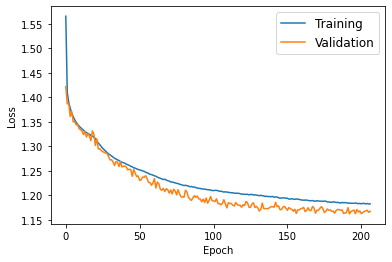

In [27]:
plt.figure()
l_train = plt.plot(np.arange(len(losses['train'])),losses['train'])
l_valid = plt.plot(np.arange(len(losses['valid'])),losses['valid'])

plt.legend(labels=['Training','Validation'],loc="best",fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [28]:
Predicts_train=torch.cat(predict['train']).cpu().detach().numpy()
Labels_train=np.argmax(torch.cat(labels['train']).cpu().detach().numpy(), axis=1)

Predicts_valid=torch.cat(predict['valid']).cpu().detach().numpy()
Labels_valid=np.argmax(torch.cat(labels['valid']).cpu().detach().numpy(), axis=1)

Predicts_test=torch.cat(predict['test']).cpu().detach().numpy()
Labels_test=np.argmax(torch.cat(labels['test']).cpu().detach().numpy(), axis=1)

In [29]:
def plot_confusion_matrix(normalize=False,
                          title=None): 
    pred = {"Training": Predicts_train, "Validation": Predicts_valid, "Test": Predicts_test}
    true = {"Training": Labels_train, "Validation": Labels_valid, "Test": Labels_test}
    fig,ax=plt.subplots(1,3,figsize=(22,5))
    for idx, key in enumerate(pred.keys()):
        y_pred=pred[key]
        y_true=true[key]
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
#         print(cm)
#     Plotting
        sns.heatmap(cm,ax=ax[idx], annot=True, annot_kws={'size':8})
        ax[idx].set_title(key,fontsize=16)
        ax[idx].set_xlabel(xlabel='Predicted label',fontsize=13)
        ax[idx].set_ylabel(ylabel='True label',fontsize=13)
    plt.suptitle(title, fontsize=20)

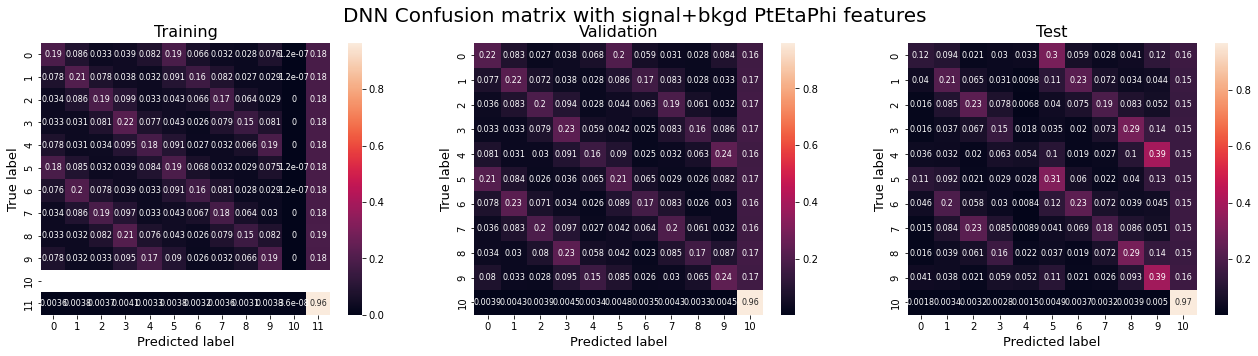

In [30]:
if args.Z_NOISE_FRACTION >0 : 
    if not args.PTETAPHI:
        plot_confusion_matrix(normalize=True,
                              title='DNN Confusion matrix with signal+bkgd p4 features')
    else:
        plot_confusion_matrix(normalize=True,
                              title='DNN Confusion matrix with signal+bkgd PtEtaPhi features')
else:
    if not args.PTETAPHI:
        plot_confusion_matrix(normalize=True,
                              title='DNN Confusion matrix with signal-only p4 features')
    else:
        plot_confusion_matrix(normalize=True,
                              title='DNN Confusion matrix with signal-only PtEtaPhi features')

### Converting bkgd raw data into npy

In [ ]:
# convert_bkgd_raw(args.BKGDPATH)

### Loading bkgd samples

In [ ]:
background_points=pickle.load(open(args.IN+'/events_w_background.pk','rb'))

In [ ]:
background=[]
background.append(background_points.train.x[background_points.train.weights.sum(axis=1)==0])
background.append(background_points.valid.x[background_points.valid.weights.sum(axis=1)==0])
background.append(background_points.test.x[background_points.test.weights.sum(axis=1)==0])

In [ ]:
background=np.concatenate(background)

In [ ]:
background=torch.tensor(background).float().to(device)

### Testing NN w/ bkgd only

In [ ]:
model.load_state_dict(torch.load(model_path+ '/'+decaymode+'_best_model.pt'))
model.eval()
with torch.no_grad():
    outputs=[]
    for i in tqdm(range(0, 400000,batch_size)):
        outputs.append(model(background[i:i+batch_size]).detach().cpu())
outputs=torch.cat(outputs)

bg_outputs=torch.argmax(torch.softmax(outputs,axis=1),axis=1).numpy()
bg_labels_counts=np.unique(bg_outputs,return_counts=True)[1]

In [ ]:
pickle.dump(bg_outputs,open(args.IN+'/NN_outputs_background_only.pk','wb'))

### Testing NN w/ signal only (Class 0)

In [ ]:
model.load_state_dict(torch.load(model_path+'/'+decaymode+'_best_model.pt'))
model.eval()
with torch.no_grad():
    signal_outputs,signal_labels=[],[]
    for batch_idx, (rhorho_s,rhorho_t,label_s,_) in enumerate(train_loader):
        signal_outputs.append(model(rhorho_s).detach().cpu())
        signal_labels.append(label_s.detach().cpu())
signal_outputs=torch.softmax(torch.cat(signal_outputs),axis=1).numpy()
signal_labels=np.concatenate(signal_labels)

####### Filtering signal outputs that are classified to Class 0
signal_outputs=signal_outputs[np.argmax(signal_labels,axis=1)==0]
signal_labels=np.argmax(signal_outputs,axis=1)

In [ ]:
pickle.dump(signal_outputs,open(args.IN+'/NN_outputs_signal_only.pk','wb'))

### Test Results

In [ ]:
bg_outputs = pickle.load(open(args.IN+'/NN_outputs_background_only.pk','rb'))
signal_outputs= pickle.load(open(args.IN+'/NN_outputs_signal_only.pk','rb'))

In [ ]:
# create the dataframe; enumerate is used to make column names
columns=['Ztt','Signal']
fig,ax=plt.subplots(dpi=150)

df = pd.concat([pd.DataFrame(a, columns=[columns[i]]) for i, a in enumerate([bg_outputs, np.argmax(signal_outputs,axis=1)], 0)], axis=1)
# plot the data
ax.set_xlim(0,args.NUM_CLASSES-1)
ax = df.plot.hist(stacked=True, bins=args.NUM_CLASSES-1,ax=ax, color = ['skyblue','red']).get_figure()
plt.xlabel("Classes")
plt.ylabel("Events")

In [ ]:
TestResults_path = os.path.join(os.getcwd()) + '/Results/TestResults/'
if not os.path.exists(TestResults_path): 
    os.mkdir(os.path.join(TestResults_path))
ax.savefig(TestResults_path+decaymode+'_TestResults.pdf')

In [ ]:
signal_df = pd.DataFrame(np.argmax(signal_outputs, axis=1), columns=[columns[1]])
bkgd_df = pd.DataFrame(bg_outputs, columns=[columns[0]])
signal_df = signal_df.groupby('Signal').size().to_frame('SgCounts').reset_index().rename({'Signal':'Class'},axis=1)
bkgd_df = bkgd_df.groupby('Ztt').size().to_frame('BgCounts').reset_index().rename({'Ztt':'Class'},axis=1)
total = pd.concat([signal_df,bkgd_df['BgCounts']],axis = 1) 

In [ ]:
fig, axis = plt.subplots(2,1,figsize=(6,10),dpi=150)
fig.suptitle( decaymode + " Test Results", fontsize=15)
axis[0].set_title('Signal + Background Results', fontsize=11)
axis[1].set_title('Background Results with Error Bar', fontsize=11)
# set plot style: grey grid in the background:
sns.set(style="dark")

total[['BgCounts','SgCounts']].plot(kind="bar", ax = axis[0],stacked=True,color = ['skyblue','r']).get_figure()

# add legend
top_bar = mpatches.Patch(color='r', label='Signal')
bottom_bar = mpatches.Patch(color='skyblue', label='Ztt')
axis[0].legend(handles=[top_bar, bottom_bar])

for i in range(len(axis)): 
    axis[i].set_xlabel("Classes",fontsize=10)
    axis[i].set_ylabel("Events",fontsize=10)


Poisson_std = [math.sqrt(i) for i in total['BgCounts'].to_numpy()]
total[['BgCounts']].plot(kind="bar", ax = axis[1],stacked=True,color = ['skyblue','r'], yerr = Poisson_std, alpha = 1)
# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
axis[1].legend(handles=[bottom_bar])

# show the graph
plt.show()

In [ ]:
TestResults_path = os.path.join(os.getcwd() + '/Results/TestResults/')
if not os.path.exists(TestResults_path): 
    os.mkdir(os.path.join(TestResults_path))
fig.savefig(TestResults_path+decaymode+'_TestResults2.pdf')

## Study the Gap Between Reconstruction-level and Truth-level Signal

### Preprocessing reconstruction-level singal

In [ ]:
events={'nn_rhorho':'RhoRhoEvent', 'nn_a1rho':'A1RhoEvent', 'nn_a1a1':'A1A1Event'}
if args.REPRO:
    args.Z_NOISE_FRACTION = 0
    args.IN = 'HiggsCP_data/'+decaymode+'/'+decaymode+'_raw_recon/'
    args.TYPE = 'nn_'+decaymode
    data, weights, argmaxs, perm, c012s, hits_argmaxs, hits_c012s = preprocess_data(args)
    event = eval(events[args.TYPE])(data, args)
    points = EventDatasets(event, weights, argmaxs, perm, c012s=c012s, hits_argmaxs=hits_argmaxs,  hits_c012s=hits_c012s, miniset=args.MINISET, unweighted=args.UNWEIGHTED)
    pickle.dump(points,open(args.IN+'/recon_events_wo_background.pk','wb'))

In [ ]:
recon_points=pickle.load(open(args.IN+'/recon_events_wo_background.pk','rb'))

In [ ]:
class ReconDataset(Dataset):
    def __init__(self, rhorho_data,rhorho_labels):
        self.rhorho_data = torch.from_numpy(rhorho_data).float().to(device)
        
        self.rhorho_labels =torch.from_numpy(rhorho_labels).float().to(device)
        
    def __getitem__(self, index):
        return self.rhorho_data[index],self.rhorho_labels[index]
    def __len__(self):
        return len(self.rhorho_labels)

In [ ]:
train_datasets_recon = ReconDataset(recon_points.train.x, recon_points.train.weights)
train_loader_recon = DataLoader(dataset = train_datasets_recon,batch_size = batch_size,shuffle = True)

valid_datasets_recon = ReconDataset(recon_points.valid.x, recon_points.valid.weights)
valid_loader_recon = DataLoader(dataset = valid_datasets_recon,batch_size = batch_size,shuffle = True)

test_datasets_recon = ReconDataset(recon_points.test.x, recon_points.test.weights)
test_loader_recon = DataLoader(dataset = test_datasets_recon,batch_size = batch_size,shuffle = True)

### Testing NN w/ reconstruction-level signal only

In [ ]:
model_path = os.path.join(os.getcwd() + '/model')
model = NeuralNetwork(num_features=recon_points.train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
# model = NeuralNetwork(num_features=points[particle_idx].train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
opt_g=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss()

In [ ]:
acc,test_loss,sample_numbers=0,0,0
model.load_state_dict(torch.load(model_path+ '/'+decaymode+'_best_model.pt'))
model.eval()
with torch.no_grad():
    recon_signal_outputs,recon_signal_labels=[],[]
    for batch_idx, (rhorho_s,label_s) in enumerate(train_loader_recon):
        signal_output = model(rhorho_s).detach().cpu()
        signal_label = label_s.detach().cpu()
        recon_signal_outputs.append(signal_output)
        recon_signal_labels.append(signal_label)
        loss=criterion(signal_output,torch.argmax(signal_label,axis=1))
        _, predictions = torch.max(signal_output, 1)
        acc+=(predictions==torch.argmax(signal_label,axis=1)).sum().item()
        test_loss+=loss.item()*len(rhorho_s)
        sample_numbers+=len(rhorho_s)
recon_signal_outputs=torch.softmax(torch.cat(recon_signal_outputs),axis=1).numpy()
recon_signal_labels=np.concatenate(recon_signal_labels)
print('\r test loss: %.3f \t acc: %.3f \t' %(test_loss/sample_numbers,acc/sample_numbers))
print('\n \r %d Reconstruction-level Samples in total'%sample_numbers)

In [ ]:
pickle.dump(recon_signal_outputs,open(args.IN+'/NN_outputs_recon_signal_only.pk','wb'))

In [ ]:
np.unique(np.argmax(recon_signal_outputs,axis=1))

In [ ]:
columns=['Reco. level NN Label','Reco. level NN Outputs']
df1 = pd.DataFrame(np.argmax(recon_signal_outputs,axis=1), columns=[columns[1]])
df2 = pd.DataFrame(np.argmax(recon_points.train.weights,axis=1), columns=[columns[0]])
df = pd.concat([df1,df2], axis=1)

fig,ax=plt.subplots(dpi=100)

sns.set_theme(style="white")
sns.histplot(data=df, binwidth = 1)
plt.xlabel("Classes")
plt.ylabel("Entries")

## Sample Reweighting Strategy

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

def column_wise_resampling(x, replacement = False, random_state = 0, **options):
    """
    Perform column-wise random resampling to break the joint distribution of p(x).
    In practice, we can perform resampling without replacement (a.k.a. permutation) to retain all the data points of feature x_j. 
    Moreover, if the practitioner has some priors on which features should be permuted,
    it can be passed through options by specifying 'sensitive_variables', by default it contains all the features
    """
    rng = np.random.RandomState(random_state)
    n, p = x.shape
    if 'sensitive_variables' in options:
        sensitive_variables = options['sensitive_variables']
    else:
        sensitive_variables = [i for i in range(p)] 
    x_decorrelation = np.zeros([n, p])
    for i in sensitive_variables:
        var = x[:, i]
        if replacement: # sampling with replacement
            x_decorrelation[:, i] = np.array([var[rng.randint(0, n)] for j in range(n)])
        else: # permutation     
            x_decorrelation[:, i] = var[rng.permutation(n)]
    return x_decorrelation

def decorrelation(x, solver = 'adam', hidden_layer_sizes = (5,5), max_iter = 500, random_state = 0):
    """
    Calcualte new sample weights by density ratio estimation
           q(x)   P(x belongs to q(x) | x) 
    w(x) = ---- = ------------------------ 
           p(x)   P(x belongs to p(x) | x)
    """
    n, p = x.shape
    x_decorrelation = column_wise_resampling(x, random_state = random_state)
    P = pd.DataFrame(x)
    Q = pd.DataFrame(x_decorrelation)
    P['src'] = 1 # 1 means source distribution
    Q['src'] = 0 # 0 means target distribution
    Z = pd.concat([P, Q], ignore_index=True, axis=0)
    labels = Z['src'].values
    Z = Z.drop('src', axis=1).values
    P, Q = P.values, Q.values
    # train a multi-layer perceptron to classify the source and target distribution
    clf = MLPClassifier(solver=solver, hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state)
    clf.fit(Z, labels)
    proba = clf.predict_proba(Z)[:len(P), 1]
    weights = (1./proba) - 1. # calculate sample weights by density ratio
    weights /= np.mean(weights) # normalize the weights to get average 1
    weights = np.reshape(weights, [n,1])
    return weights

In [ ]:
train_weights_SRDO = torch.from_numpy(decorrelation(points.train.x)).to(device)
# valid_weights_SRDO = torch.from_numpy(decorrelation(points.valid.x)).to(device)
# test_weights_SRDO = torch.from_numpy(decorrelation(points.test.x)).to(device)

In [ ]:
sns.histplot(pd.DataFrame(train_weights_SRDO.cpu().numpy()).sort_values(0).iloc[:-10000])

In [ ]:
model_path = os.path.join(os.getcwd() + '/model')
model = NeuralNetwork(num_features=points.train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
# model = NeuralNetwork(num_features=points[particle_idx].train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
opt_g=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss(reduction='none')
early_stopping = EarlyStopping(patience=12, verbose=True,path=model_path+'/'+decaymode+'_best_model_truth_SRDO.pt')

In [ ]:
epoch=200
with open('Results/TrainingOutputs/'+decaymode+'_TrainingOutputs_truth_SRDO.txt','wb') as f:
    for i in range(epoch):
        model.train()
        train_loss,sample_numbers,acc,total_samples,bg_acc=0,0,0,0,0
        for batch_idx, (rhorho_s,_,label_s,_,idx) in enumerate(train_loader_truth):
            opt_g.zero_grad()
            outputs=model(rhorho_s)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=(train_weights_SRDO[idx]*criterion(outputs,torch.argmax(label_s,axis=1))).mean()
#                 loss=criterion(outputs,torch.argmax(label_s,axis=1)).mean()
                _, predictions = torch.max(outputs, 1)
                acc+=(predictions==torch.argmax(label_s,axis=1)).sum().item()
            else:
                loss=(train_weights_SRDO[idx]*criterion(outputs,label_s)).mean()
            loss.backward()
            train_loss+=loss.item()*len(rhorho_s)
            sample_numbers+=len(rhorho_s)
            opt_g.step()
            print('\r training loss: %.3f \t acc: %.3f \t' %(train_loss/sample_numbers,acc/sample_numbers),end='')
        f.write(('\r training loss: %.3f \t acc: %.3f \t ' %(train_loss/sample_numbers,acc/sample_numbers)).encode())
        print()
        valid_loss,valid_acc,valid_numbers,total_samples,bg_acc=0,0,0,0,0
        model.eval()
        with torch.no_grad():
            for batch_idx, (_,rhorho_t,_,label_t,idx) in enumerate(valid_loader_truth):
                outputs=model(rhorho_t)
                _, predictions = torch.max(outputs, 1)
                valid_acc+=(predictions==torch.argmax(label_t,axis=1)).sum().item()
                valid_numbers+=len(rhorho_t)
                if isinstance(criterion,nn.CrossEntropyLoss):
                    loss=criterion(outputs,torch.argmax(label_t,axis=1)).mean()
                else:
                    loss=criterion(outputs,label_t).mean()
                valid_loss+=loss.item()*len(rhorho_t)              
        print()
        print('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers),end='')
        f.write(('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers)).encode())
        print()
        early_stopping(-valid_acc/valid_numbers,model)
        if early_stopping.early_stop:
            print("Early stopping")
            f.write(("Early stopping").encode())
            break;

In [ ]:
acc,test_loss,sample_numbers=0,0,0
model.load_state_dict(torch.load(model_path+ '/'+decaymode+'_best_model_truth_SRDO.pt'))
model.eval()
with torch.no_grad():
    recon_signal_outputs,recon_signal_labels=[],[]
    for batch_idx, (rhorho_s,label_s) in enumerate(test_loader_recon):
        signal_output = model(rhorho_s).detach().cpu()
        signal_label = label_s.detach().cpu()
        recon_signal_outputs.append(signal_output)
        recon_signal_labels.append(signal_label)
        loss=criterion(signal_output,torch.argmax(signal_label,axis=1)).mean()
        _, predictions = torch.max(signal_output, 1)
        acc+=(predictions==torch.argmax(signal_label,axis=1)).sum().item()
        test_loss+=loss.item()*len(rhorho_s)
        sample_numbers+=len(rhorho_s)
recon_signal_outputs=torch.softmax(torch.cat(recon_signal_outputs),axis=1).numpy()
recon_signal_labels=np.concatenate(recon_signal_labels)
print('\r test loss: %.3f \t acc: %.3f \t' %(test_loss/sample_numbers,acc/sample_numbers))
print('\n \r %d Reconstruction-level Samples in total'%sample_numbers)